# Lab: Stock Market Analysis and Trading Strategies

In this lab, we will walk through the process of:
1. Importing real-world financial data from APIs — no more copy-pasting from websites into Excel.
2. Cleaning and processing messy data that has missing values and formatting issues.
3. Thinking about data as **complete datasets** rather than individual cells — the key mindset shift from Excel to Python.
4. Calculating technical indicators (Moving Averages, Bollinger Bands) to analyze stock trends and volatility.
5. Implementing a simple trading strategy and **backtesting** it against historical data.
6. Building interactive visualizations that let you explore different stocks and time periods.

**Important Disclaimer:** This lab is for *educational purposes only*. Stock trading involves significant risk, and past performance does not guarantee future results.


---

## 0. Setup

Run the cell below to install and import the libraries we'll use throughout this lab.


In [7]:
# Run this cell — installs and imports all required packages
try:
    import yfinance as yf
except ImportError:
    !pip install yfinance
    import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print("✓ All libraries loaded successfully!")


Matplotlib is building the font cache; this may take a moment.


✓ All libraries loaded successfully!


---

## 1. Importing Stock Data

In Excel, getting stock data usually means going to a website, copying a table, and pasting it into a spreadsheet — one stock at a time. In Python, we can download years of data for multiple stocks in a single line of code.

We'll use the `yfinance` library, which pulls historical price data directly from Yahoo Finance.


In [8]:
# Run this cell — download 5 years of data for several stocks
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']

stock_data = {}
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, period='5y', progress=False)
    print(f"✓ {ticker}: {len(stock_data[ticker]):,} trading days downloaded")

# We'll focus on Apple for most of the lab
aapl = stock_data['AAPL'].copy()

print(f"\nDate range: {aapl.index.min().date()} to {aapl.index.max().date()}")
print(f"Total rows: {len(aapl):,}")


✓ AAPL: 1,255 trading days downloaded
✓ GOOGL: 1,255 trading days downloaded
✓ MSFT: 1,255 trading days downloaded
✓ AMZN: 1,255 trading days downloaded
✓ TSLA: 1,255 trading days downloaded

Date range: 2021-02-26 to 2026-02-25
Total rows: 1,255


Let's look at the first few rows. Notice how the data is organized — each **row** is a trading day and each **column** is a measurement. This is fundamentally different from Excel, where you might think about individual cells. In pandas, we think about *entire columns* at once.


In [9]:
# Run this cell — preview the data
aapl.head(10)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-02-26,118.106682,121.603322,118.048237,119.402090,164560400
2021-03-01,124.466888,124.603247,119.596911,120.531946,116307900
2021-03-02,121.866318,125.372700,121.759178,125.070764,102260900
2021-03-03,118.885895,122.440980,118.671615,121.564383,112966300
2021-03-04,117.006088,120.385854,115.535360,118.583964,178155000
2021-03-05,118.262543,118.769025,114.512661,117.833990,153766600
2021-03-08,113.334122,117.853460,113.188021,117.785281,154376600
2021-03-09,117.941101,118.885878,115.700916,115.934673,129525800


**Question 1:** How many columns does the stock data have? What does each column represent? How would you describe the difference between "Open" and "Close" price?

*Type your answer here, replacing this text.*


---

## 2. Data Cleaning: Dealing with Messy Real-World Data

Real-world data is rarely perfect. Stock data can have missing values (holidays, market closures, data errors), incorrect types, or gaps. Let's inspect the data quality before we do any analysis.

In Excel, you might scan through rows visually. In pandas, we can check the *entire dataset* in one command.


In [10]:
# Run this cell — check for missing values across ALL columns at once
print("=== Missing Values per Column ===")
print(aapl.isnull().sum())

print(f"\nTotal missing cells: {aapl.isnull().sum().sum()}")
print(f"Dataset shape: {aapl.shape[0]} rows × {aapl.shape[1]} columns")
print(f"Data types:\n{aapl.dtypes}")


=== Missing Values per Column ===
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Total missing cells: 0
Dataset shape: 1255 rows × 5 columns
Data types:
Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object


Even if there are no missing values, it's good practice to check. Now let's look at basic statistics — the equivalent of using Excel's `AVERAGE()`, `MIN()`, `MAX()`, and `STDEV()` on every column simultaneously.


In [11]:
# Run this cell — summary statistics for all columns at once
aapl.describe().round(2)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1255.00,1255.00,1255.00,1255.00,1255.0
mean,183.32,185.13,181.35,183.13,68233141.1
std,41.48,41.78,41.17,41.47,29150246.8
min,113.33,117.27,113.19,115.93,17910600.0
25%,148.15,149.39,146.26,147.82,47597650.0
50%,174.26,175.89,172.13,174.14,61172200.0
75%,215.93,217.85,213.04,215.07,81521050.0
max,285.92,288.35,283.04,285.93,318679900.0


**TO-DO:** Sometimes stock data has days where the volume is zero or unusually low, which can indicate data quality issues. Write code to find any days where the trading volume was below 1,000,000 shares.

*Hint:* Use boolean indexing — `df[df['column'] < value]`


In [12]:
# TO-DO: Find days with unusually low volume
low_volume_days = aapl[aapl['Volume'] < ...]

print(f"Days with volume below 1,000,000: {len(low_volume_days)}")
low_volume_days[['Close', 'Volume']].head(10)


TypeError: '<' not supported between instances of 'int' and 'ellipsis'

**Question 2:** Why might some trading days have very low volume? What could cause this in the real stock market?

*Type your answer here, replacing this text.*


---

## 3. Calculating Daily Returns

Before diving into indicators, let's compute **daily returns** — the percentage change in closing price from one day to the next. This is a fundamental measure in finance.

In Excel, you'd write a formula like `=(B3-B2)/B2` and drag it down. In pandas, one method call handles the entire column.


In [13]:
# Run this cell — calculate daily returns
aapl['Daily_Return'] = aapl['Close'].pct_change() * 100  # as percentage

print("=== Daily Returns (%) ===")
print(aapl[['Close', 'Daily_Return']].tail(10).to_string())

print(f"\nAverage daily return: {aapl['Daily_Return'].mean():.4f}%")
print(f"Std dev of daily returns: {aapl['Daily_Return'].std():.4f}%")
print(f"Best single day: {aapl['Daily_Return'].max():.2f}%")
print(f"Worst single day: {aapl['Daily_Return'].min():.2f}%")


=== Daily Returns (%) ===
Price            Close Daily_Return
Ticker            AAPL             
Date                               
2026-02-11  275.500000     0.665013
2026-02-12  261.730011    -4.998181
2026-02-13  255.779999    -2.273340
2026-02-17  263.880005     3.166786
2026-02-18  264.350006     0.178112
2026-02-19  260.579987    -1.426147
2026-02-20  264.579987     1.535037
2026-02-23  266.179993     0.604734
2026-02-24  272.140015     2.239095
2026-02-25  274.230011     0.767986

Average daily return: 0.0824%
Std dev of daily returns: 1.7481%
Best single day: 15.33%
Worst single day: -9.25%


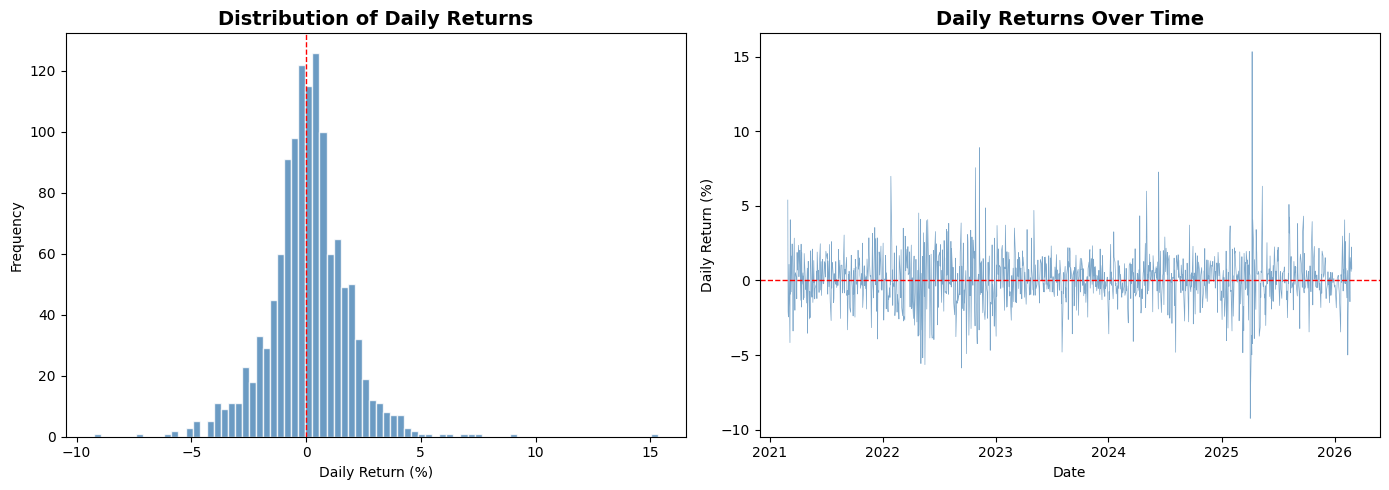

In [14]:
# Run this cell — visualize the distribution of daily returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(aapl['Daily_Return'].dropna(), bins=80, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Distribution of Daily Returns', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Daily Return (%)')
axes[0].set_ylabel('Frequency')

# Time series
axes[1].plot(aapl.index, aapl['Daily_Return'], color='steelblue', linewidth=0.5, alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Daily Returns Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily Return (%)')

plt.tight_layout()
plt.show()


**Question 3:** Looking at the histogram, does the distribution of daily returns look symmetric? What does the shape of this distribution tell you about how stock prices move?

*Type your answer here, replacing this text.*


---

## 4. Moving Averages (MA)

A **moving average** smooths out daily price fluctuations to reveal the underlying trend. It's one of the most widely used tools in technical analysis.

- **Short-term MA** (e.g., 20-day): Reacts quickly to price changes — captures recent trends.
- **Long-term MA** (e.g., 50-day): Slower to react — shows the broader direction.

In Excel, you'd use `=AVERAGE(B2:B21)` and drag it down, shifting the window one row each time. In pandas, the `.rolling()` method does this across the entire column.


In [15]:
# Run this cell — calculate 20-day and 50-day moving averages
aapl['MA_20'] = aapl['Close'].rolling(window=20).mean()
aapl['MA_50'] = aapl['Close'].rolling(window=50).mean()

print("Last 10 days with moving averages:")
aapl[['Close', 'MA_20', 'MA_50']].tail(10)


Last 10 days with moving averages:


Price,Close,MA_20,MA_50
Ticker,AAPL,,
Date,,,
2026-02-11,275.500000,262.099789,268.275185
2026-02-12,261.730011,262.200441,267.853078
2026-02-13,255.779999,262.091011,267.250229
2026-02-17,263.880005,262.520455,266.850142
2026-02-18,264.350006,263.414487,266.528390
2026-02-19,260.579987,264.072562,266.169602
2026-02-20,264.579987,264.895669,265.908597
2026-02-23,266.179993,265.814262,265.693780


**TO-DO:** Add a 200-day moving average to the dataframe. The 200-day MA is commonly used to identify long-term market trends.


In [16]:
# TO-DO: Calculate the 200-day moving average
aapl['MA_200'] = aapl['Close'].rolling(window=...).mean()

# Verify it worked
print("200-day MA (last 5 days):")
print(aapl[['Close', 'MA_200']].tail())


ValueError: window must be an integer 0 or greater

KeyError: 'MA_200'

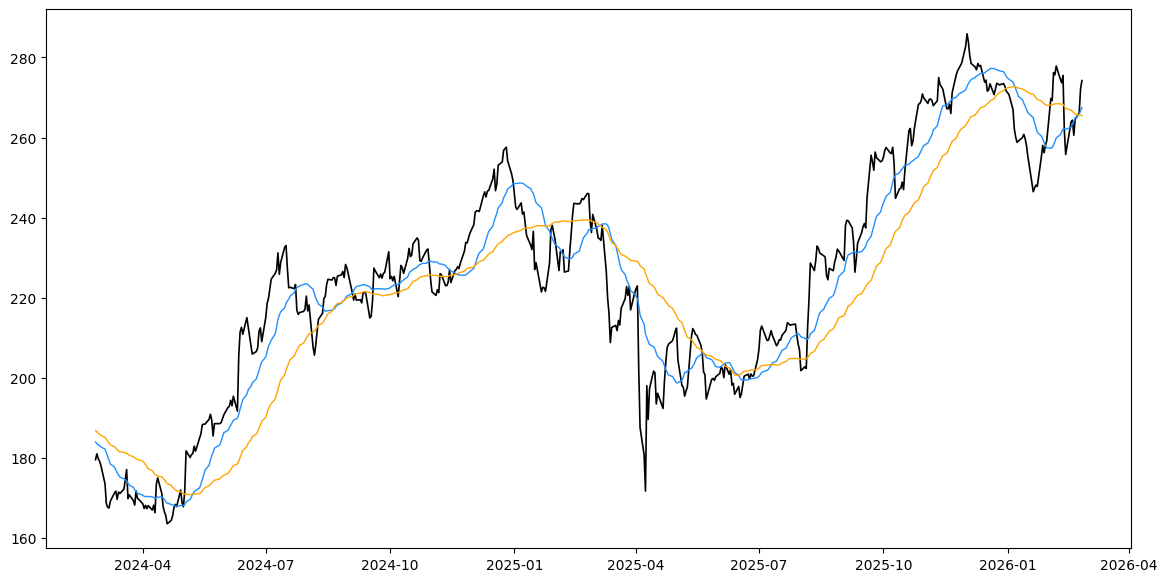

In [17]:
# Run this cell — plot closing price with all three moving averages (last 2 years)
last_2y = aapl.loc[aapl.index >= aapl.index.max() - pd.DateOffset(years=2)]

plt.figure(figsize=(14, 7))
plt.plot(last_2y.index, last_2y['Close'], label='Closing Price', color='black', linewidth=1.2)
plt.plot(last_2y.index, last_2y['MA_20'], label='20-day MA', color='dodgerblue', linewidth=1)
plt.plot(last_2y.index, last_2y['MA_50'], label='50-day MA', color='orange', linewidth=1)
plt.plot(last_2y.index, last_2y['MA_200'], label='200-day MA', color='red', linewidth=1, linestyle='--')

plt.title('Apple Stock Price with Moving Averages', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Question 4:** When the 20-day MA crosses *above* the 50-day MA, traders call this a "Golden Cross" — a bullish signal. When it crosses *below*, it's a "Death Cross" — bearish. Can you spot any of these crossovers in the chart above? What happened to the price afterward?

*Type your answer here, replacing this text.*


---

## 5. Bollinger Bands

**Bollinger Bands** are a volatility indicator built from three lines:

1. **Middle Band**: 20-day Simple Moving Average (SMA)
2. **Upper Band**: SMA + 2 × (20-day standard deviation)
3. **Lower Band**: SMA − 2 × (20-day standard deviation)

The idea is simple — if the price moves outside the bands, the stock may be **overbought** (above upper band) or **oversold** (below lower band). Statistically, about 95% of closing prices should fall within the bands.

In Excel, you'd need separate columns for the SMA, standard deviation, upper band, and lower band — each with a formula dragged across hundreds of rows. In pandas, it's a few lines.


**TO-DO:** Calculate Bollinger Bands. Fill in the missing parts:


In [18]:
# TO-DO: Calculate Bollinger Bands
bb_window = 20

# Step 1: Calculate the 20-day SMA (middle band)
aapl['BB_Middle'] = aapl['Close'].rolling(bb_window).mean()

# Step 2: Calculate the 20-day rolling standard deviation
# Hint: Use .rolling(bb_window).std()
aapl['BB_Std'] = aapl['Close'].rolling(bb_window)...

# Step 3: Calculate Upper Band = Middle + 2 * Std
aapl['BB_Upper'] = aapl['BB_Middle'] + (... * aapl['BB_Std'])

# Step 4: Calculate Lower Band = Middle - 2 * Std
aapl['BB_Lower'] = aapl['BB_Middle'] - (... * aapl['BB_Std'])

print("Bollinger Bands (last 5 days):")
aapl[['Close', 'BB_Upper', 'BB_Middle', 'BB_Lower']].tail()


SyntaxError: invalid syntax (1168226887.py, line 9)

KeyError: 'BB_Middle'

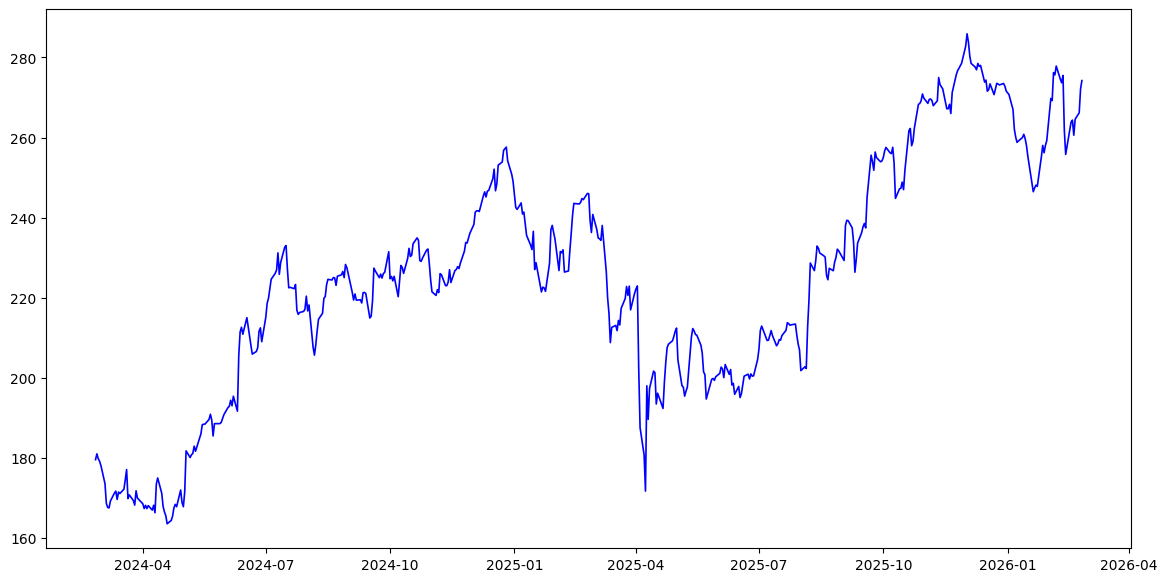

In [19]:
# Run this cell — plot Bollinger Bands (last 2 years)
last_2y = aapl.loc[aapl.index >= aapl.index.max() - pd.DateOffset(years=2)]

plt.figure(figsize=(14, 7))
plt.plot(last_2y.index, last_2y['Close'], label='Closing Price', color='blue', linewidth=1.2)
plt.plot(last_2y.index, last_2y['BB_Middle'], label='SMA (20-day)', color='black', linestyle='--', linewidth=1)
plt.plot(last_2y.index, last_2y['BB_Upper'], label='Upper Band', color='red', linewidth=0.8)
plt.plot(last_2y.index, last_2y['BB_Lower'], label='Lower Band', color='green', linewidth=0.8)
plt.fill_between(last_2y.index, last_2y['BB_Upper'], last_2y['BB_Lower'], color='gray', alpha=0.15)

plt.title('Apple Stock — Bollinger Bands (Last 2 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**TO-DO:** Identify overbought and oversold days in the last 2 years. Use boolean indexing to find days where the closing price was above the upper band or below the lower band.


In [20]:
# TO-DO: Find overbought and oversold days
# Hint: overbought means Close > BB_Upper, oversold means Close < BB_Lower

overbought = last_2y[last_2y['Close'] ... last_2y['BB_Upper']]
oversold = last_2y[last_2y['Close'] ... last_2y['BB_Lower']]

print(f"Overbought days (last 2 years): {len(overbought)}")
print(f"Oversold days (last 2 years): {len(oversold)}")

if len(overbought) > 0:
    print("\nMost recent overbought dates:")
    print(overbought[['Close', 'BB_Upper']].tail())

if len(oversold) > 0:
    print("\nMost recent oversold dates:")
    print(oversold[['Close', 'BB_Lower']].tail())


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3655789479.py, line 4)

**Question 5:** Looking at the Bollinger Bands chart, can you identify any periods where the bands became very wide or very narrow? What does the *width* of the bands tell you about the stock's volatility during those periods?

*Type your answer here, replacing this text.*


---

## 6. Trading Strategy: Moving Average Crossover

Now let's combine what we've learned into a simple **trading strategy** and test whether it would have made money historically. This process is called **backtesting**.

**The strategy:**
- **BUY** when the 20-day MA crosses *above* the 50-day MA (upward momentum)
- **SELL** when the 20-day MA crosses *below* the 50-day MA (downward momentum)
- Otherwise, **HOLD** your current position

This is one of the simplest algorithmic trading strategies. Let's see how it performs.


**TO-DO:** Create buy/sell signals based on the MA crossover rule. Fill in the signal values.


In [22]:
# TO-DO: Generate trading signals
# Signal =  1 → BUY / HOLD long position
# Signal = -1 → SELL / SHORT position

aapl['Signal'] = 0

# When 20-day MA is above 50-day MA → bullish → signal = ?
aapl.loc[aapl['MA_20'] > aapl['MA_50'], 'Signal'] = ...

# When 20-day MA is below 50-day MA → bearish → signal = ?
aapl.loc[aapl['MA_20'] < aapl['MA_50'], 'Signal'] = ...

# Detect crossovers: where the signal changes
aapl['Crossover'] = aapl['Signal'].diff()

buy_signals = aapl[aapl['Crossover'] == 2]   # -1 → +1 = change of 2
sell_signals = aapl[aapl['Crossover'] == -2]  # +1 → -1 = change of -2

print(f"Total BUY signals:  {len(buy_signals)}")
print(f"Total SELL signals: {len(sell_signals)}")


TypeError: unsupported operand type(s) for -: 'ellipsis' and 'int'

In [21]:
# Run this cell — visualize the buy/sell signals on the price chart (last 3 years)
last_3y = aapl.loc[aapl.index >= aapl.index.max() - pd.DateOffset(years=3)]
buys_3y = buy_signals.loc[buy_signals.index >= last_3y.index.min()]
sells_3y = sell_signals.loc[sell_signals.index >= last_3y.index.min()]

plt.figure(figsize=(14, 7))
plt.plot(last_3y.index, last_3y['Close'], label='Closing Price', color='black', linewidth=1)
plt.plot(last_3y.index, last_3y['MA_20'], label='20-day MA', color='dodgerblue', linewidth=0.9)
plt.plot(last_3y.index, last_3y['MA_50'], label='50-day MA', color='orange', linewidth=0.9)

plt.scatter(buys_3y.index, buys_3y['Close'], marker='^', color='green', s=120,
            label='BUY Signal', zorder=5, edgecolors='black', linewidth=0.5)
plt.scatter(sells_3y.index, sells_3y['Close'], marker='v', color='red', s=120,
            label='SELL Signal', zorder=5, edgecolors='black', linewidth=0.5)

plt.title('Moving Average Crossover — Buy & Sell Signals (Last 3 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'buy_signals' is not defined

**Question 6:** Look at the buy/sell signal chart. Are there any signals that appear to be "wrong" — for example, a buy signal right before the price dropped, or a sell signal right before a rally? Why might this happen with a moving-average-based strategy?

*Type your answer here, replacing this text.*


---

## 7. Backtesting: Did the Strategy Make Money?

**Backtesting** means applying a trading strategy to *historical* data to see how it would have performed. We'll compare:

1. **Buy & Hold**: Buy Apple stock at the start and hold for the entire period.
2. **MA Crossover Strategy**: Follow the buy/sell signals we just created.


In [23]:
# Run this cell — backtest the MA crossover strategy

# Use last 3 years for the backtest
bt = last_3y[['Close', 'Signal']].copy()
bt = bt.dropna()

# Daily returns
bt['Market_Return'] = bt['Close'].pct_change()

# Strategy return: only earn market return when Signal = 1 (long position)
# When Signal = -1, we assume we're in cash (0% return)
bt['Strategy_Return'] = bt['Market_Return'] * bt['Signal'].shift(1)

# Cumulative returns (growth of $1)
bt['Buy_Hold_Growth'] = (1 + bt['Market_Return']).cumprod()
bt['Strategy_Growth'] = (1 + bt['Strategy_Return']).cumprod()

# Final results
bh_total = (bt['Buy_Hold_Growth'].iloc[-1] - 1) * 100
st_total = (bt['Strategy_Growth'].iloc[-1] - 1) * 100

print("=" * 50)
print("        BACKTEST RESULTS (Last 3 Years)")
print("=" * 50)
print(f"  Buy & Hold Return:      {bh_total:+.2f}%")
print(f"  MA Crossover Return:    {st_total:+.2f}%")
print(f"  Difference:             {st_total - bh_total:+.2f}%")
print("=" * 50)

if st_total > bh_total:
    print("  → Strategy OUTPERFORMED buy & hold")
else:
    print("  → Strategy UNDERPERFORMED buy & hold")


KeyError: "['Signal'] not in index"

In [24]:
# Run this cell — plot cumulative growth comparison
plt.figure(figsize=(14, 7))
plt.plot(bt.index, bt['Buy_Hold_Growth'], label='Buy & Hold', color='blue', linewidth=1.5)
plt.plot(bt.index, bt['Strategy_Growth'], label='MA Crossover Strategy', color='green', linewidth=1.5)

plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.fill_between(bt.index, bt['Buy_Hold_Growth'], bt['Strategy_Growth'],
                 where=(bt['Strategy_Growth'] > bt['Buy_Hold_Growth']),
                 color='green', alpha=0.1, label='Strategy Winning')
plt.fill_between(bt.index, bt['Buy_Hold_Growth'], bt['Strategy_Growth'],
                 where=(bt['Strategy_Growth'] <= bt['Buy_Hold_Growth']),
                 color='red', alpha=0.1, label='Buy & Hold Winning')

plt.title('Growth of $1: Buy & Hold vs MA Crossover Strategy', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'bt' is not defined

<Figure size 1400x700 with 0 Axes>

**Question 7:** Did the MA crossover strategy beat simply buying and holding? Why do you think simple strategies like this often struggle to outperform buy & hold in the long run?

*Type your answer here, replacing this text.*


---

## 8. Risk Analysis

Return is only half the picture — we also need to measure **risk**. A strategy that makes more money but has wild swings may not be better. Let's compare the risk profiles.


In [25]:
# Run this cell — compare risk metrics
def risk_report(returns, label):
    """Calculate key risk metrics for a return series."""
    annual_return = returns.mean() * 252 * 100
    annual_vol = returns.std() * np.sqrt(252) * 100
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    max_dd = ((1 + returns).cumprod() / (1 + returns).cumprod().cummax() - 1).min() * 100
    return {
        'Strategy': label,
        'Annual Return (%)': f"{annual_return:.2f}",
        'Annual Volatility (%)': f"{annual_vol:.2f}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown (%)': f"{max_dd:.2f}"
    }

bh_metrics = risk_report(bt['Market_Return'].dropna(), 'Buy & Hold')
st_metrics = risk_report(bt['Strategy_Return'].dropna(), 'MA Crossover')

risk_df = pd.DataFrame([bh_metrics, st_metrics]).set_index('Strategy')
risk_df


NameError: name 'bt' is not defined

**Key terms explained:**
- **Annual Volatility**: How much the returns fluctuate year-to-year. Lower is more stable.
- **Sharpe Ratio**: Return per unit of risk. Higher is better. Above 1.0 is generally considered good.
- **Max Drawdown**: The largest peak-to-trough decline. This tells you the worst-case scenario — how much you could have lost at the worst possible time.

**Question 8:** Compare the Sharpe Ratios and Max Drawdowns of both strategies. Even if one strategy has a lower total return, could it still be "better" from a risk perspective? Why might an investor prefer a lower-return strategy with lower risk?

*Type your answer here, replacing this text.*


---

## 9. Interactive Stock Explorer

Now let's put everything together into an interactive tool. Use the dropdown and slider below to analyze different stocks and time windows. The widget calculates Bollinger Bands and identifies overbought/oversold conditions automatically.


In [26]:
# Run this cell — build the interactive stock analyzer

def analyze_stock(ticker, years):
    """Generate Bollinger Band analysis for a given stock and time window."""
    df = stock_data[ticker].copy()
    cutoff = df.index.max() - pd.DateOffset(years=years)
    
    # Calculate Bollinger Bands on full data, then filter
    df['BB_Mid'] = df['Close'].rolling(20).mean()
    df['BB_Std'] = df['Close'].rolling(20).std()
    df['BB_Up'] = df['BB_Mid'] + 2 * df['BB_Std']
    df['BB_Lo'] = df['BB_Mid'] - 2 * df['BB_Std']
    
    df = df.loc[df.index >= cutoff]
    
    overbought = df[df['Close'] > df['BB_Up']]
    oversold = df[df['Close'] < df['BB_Lo']]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(df.index, df['Close'], label='Close', color='blue', linewidth=1.2)
    ax.plot(df.index, df['BB_Mid'], label='SMA (20)', color='black', linestyle='--', linewidth=0.9)
    ax.plot(df.index, df['BB_Up'], color='red', linewidth=0.7)
    ax.plot(df.index, df['BB_Lo'], color='green', linewidth=0.7)
    ax.fill_between(df.index, df['BB_Up'], df['BB_Lo'], color='gray', alpha=0.12)
    
    if len(overbought) > 0:
        ax.scatter(overbought.index, overbought['Close'], color='red',
                   marker='v', s=60, zorder=5, label=f'Overbought ({len(overbought)})')
    if len(oversold) > 0:
        ax.scatter(oversold.index, oversold['Close'], color='green',
                   marker='^', s=60, zorder=5, label=f'Oversold ({len(oversold)})')
    
    ax.set_title(f'{ticker} — Bollinger Bands ({years} Year{"s" if years > 1 else ""})',
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    latest = df.iloc[-1]
    print(f"  Latest Close: ${latest['Close']:.2f}")
    print(f"  Upper Band:   ${latest['BB_Up']:.2f}")
    print(f"  Lower Band:   ${latest['BB_Lo']:.2f}")
    status = "OVERBOUGHT" if latest['Close'] > latest['BB_Up'] else \
             "OVERSOLD" if latest['Close'] < latest['BB_Lo'] else "NORMAL"
    print(f"  Current Status: {status}")


# Build widget interface
stock_dropdown = widgets.Dropdown(options=tickers, value='AAPL', description='Stock:')
years_slider = widgets.IntSlider(value=2, min=1, max=5, step=1, description='Years:')
out = widgets.Output()

def on_change(_):
    with out:
        out.clear_output(wait=True)
        analyze_stock(stock_dropdown.value, years_slider.value)

stock_dropdown.observe(on_change, names='value')
years_slider.observe(on_change, names='value')

print("=== INTERACTIVE STOCK ANALYZER ===")
display(widgets.HBox([stock_dropdown, years_slider]))
display(out)
on_change(None)


=== INTERACTIVE STOCK ANALYZER ===


Output()

**TO-DO:** Use the interactive widget to analyze a stock other than Apple. Answer the following:

**Question 9:** Which stock did you choose? Is it currently overbought, oversold, or in the normal range? Compare the band width to Apple's — which stock appears more volatile?

*Type your answer here, replacing this text.*


---

## 10. Your Turn: Analyze a Stock of Your Choice

In the cell below, download data for a stock that is *not* in our original list. You can find ticker symbols on [Yahoo Finance](https://finance.yahoo.com/).

Complete the following tasks:
1. Download the data using `yf.download()`
2. Calculate 20-day and 50-day moving averages
3. Calculate Bollinger Bands
4. Create at least one visualization


In [27]:
# TO-DO: Choose your own stock and perform the analysis

# Step 1: Download data (replace 'NFLX' with any ticker you want)
my_stock = yf.download('...', period='5y', progress=False)

# Step 2: Calculate moving averages
my_stock['MA_20'] = ...
my_stock['MA_50'] = ...

# Step 3: Calculate Bollinger Bands
my_stock['BB_Mid'] = ...
my_stock['BB_Std'] = ...
my_stock['BB_Upper'] = ...
my_stock['BB_Lower'] = ...

# Step 4: Create a plot (at least one visualization)
plt.figure(figsize=(14, 7))
# ... your plotting code here ...
plt.show()


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: ..."}}}
$...: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['...']: possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")


<Figure size 1400x700 with 0 Axes>

**Question 10:** Describe what you found for your chosen stock. Does it show different behavior compared to Apple? Would the MA crossover strategy have worked better or worse on this stock? What might explain the differences?

*Type your answer here, replacing this text.*


---

## 11. Reflection: Excel vs Python for Data Analysis

**Question 11:** Based on your experience in this lab, list at least 3 advantages of using Python/pandas for stock analysis compared to doing the same work in Excel. Then list at least 1 situation where Excel might still be preferable.

*Type your answer here, replacing this text.*


**Question 12:** Think about the backtesting process. In Excel, you'd need to write formulas row-by-row, then manually calculate cumulative returns. In Python, we did it in a few lines. How does this relate to the concept of *automation* in data analysis?

*Type your answer here, replacing this text.*


---

## Bonus Challenge (Optional)

Try to improve the MA crossover strategy. Some ideas:

1. **Different MA periods:** Instead of 20 and 50, try 10 and 30, or 50 and 200. Does performance change?
2. **Add a volume filter:** Only trade when volume is above its 20-day average.
3. **Combine indicators:** Use *both* MA crossover and Bollinger Bands — for example, only buy when the MA signal is bullish AND price is near the lower Bollinger Band.
4. **Test multiple stocks:** Run your strategy on all 5 stocks and compare results.


In [ ]:
# Bonus: Experiment with strategy improvements here



---

## Summary

In this lab, you learned to:

- ✓ Import live stock data using Python APIs — replacing manual copy-paste from websites
- ✓ Clean and inspect data quality across an entire dataset at once
- ✓ Calculate daily returns, moving averages, and Bollinger Bands
- ✓ Implement a trading strategy and backtest it against historical data
- ✓ Measure risk using volatility, Sharpe Ratio, and maximum drawdown
- ✓ Build interactive visualizations for exploring different stocks

**Key takeaway:** Python and pandas let you work with data as *complete sets* — calculating indicators across thousands of rows simultaneously, automating repetitive analysis, and testing ideas that would take hours to set up in Excel. This is the foundation of data-driven decision making.

**Important reminder:** This lab is for educational purposes only. Real stock trading involves significant financial risk. Always consult a qualified financial advisor before making investment decisions.
